# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

from scipy.stats import percentileofscore
import time
import math

# Training data

In [2]:
df = pd.read_parquet('../pipeline/tmp/cities/poz-w/dataset_50_stops.parquet')
df.head(5)

,from_x,from_y,to_x,to_y,day_type,start,reference,time
0,0.994687,-1.925553,-0.141699,0.518964,0,0.504468,3251,5715
1,0.994687,-1.925553,0.216683,-0.231768,0,0.504468,1627,3158
2,-0.767035,1.589467,0.254793,0.689781,2,0.099178,2657,8527
3,0.455074,-0.001201,0.078837,0.048088,1,0.783380,744,1394
4,-1.071253,-0.765113,0.302267,-0.454654,0,0.679792,3483,5585


In [3]:
print(df.size)

32000000


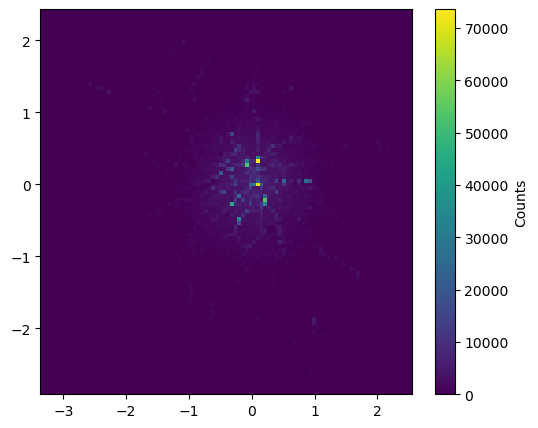

In [4]:
x = df['to_x']
y = df['to_y']

plt.figure(figsize=(6, 5))
plt.hist2d(x, y, bins=100, cmap='viridis')

plt.colorbar(label='Counts')

In [56]:
X = df[['from_x', 'from_y', 'to_x', 'to_y', 'day_type', 'start']]
y = df['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Preprocessing

In [6]:
class CustomScalerLayer(Layer):
    def __init__(self, city_diameter=25000, **kwargs):
        super(CustomScalerLayer, self).__init__(**kwargs)
        self.city_diameter = city_diameter

    def call(self, inputs):
        # Normalize coordinates
        from_x = (inputs[:, 0] / self.city_diameter) + 0.5
        from_y = (inputs[:, 1] / self.city_diameter) + 0.5
        to_x = (inputs[:, 2] / self.city_diameter) + 0.5
        to_y = (inputs[:, 3] / self.city_diameter) + 0.5

        # Normalize start time
        start = inputs[:, 5] / 86400.0  # 86400 seconds in a day

        # Combine normalized features
        normalized_inputs = tf.stack([from_x, from_y, to_x, to_y, inputs[:, 4], start], axis=1)
        return normalized_inputs

In [7]:
scaler_layer = CustomScalerLayer()

# Model definition

## architecture

In [8]:
model = Sequential([
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(4, activation='relu', kernel_initializer=HeNormal()),
    Dense(1, activation='exponential'),
])

In [9]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr * 0.1
    else:
        return lr

In [10]:
class BatchLearningRateScheduler(Callback):
    def __init__(self, total_batches):
        super(BatchLearningRateScheduler, self).__init__()
        self.total_batches = total_batches
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch

    def on_batch_begin(self, batch, logs=None):
        if self.current_epoch == 0 and batch < self.total_batches:
            lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            ratio = (batch + 1) / self.total_batches
            divisor = ratio if ratio > 0.1 else 0.1
            new_lr = lr * divisor
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
        elif self.current_epoch > 0:
            lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [11]:
total_batches = 3000
batch_lr_scheduler = BatchLearningRateScheduler(total_batches)
simple_lr_scheduler = LearningRateScheduler(scheduler)

## loss function

In [12]:
def quadrtic(ratio):
    return (1-ratio)**2

def squized_sigmoid(ratio):
    return 1/(1 + tf.math.exp(-30*(ratio-1)))

In [13]:
def asymetric_loss_function(y_true, y_pred):
    #y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    
    #tf.print("y_true:", y_true, summarize=-1)
    #tf.print("y_pred:", y_pred, summarize=-1)

    tf.debugging.assert_all_finite(y_pred, "y_pred contains NaN values!")
    
    tf.debugging.assert_greater_equal(
        tf.reduce_min(y_pred), tf.constant(0.0, dtype=tf.float32),
        message=f"y_pred contains negative values! {y_pred}"
    )

    ratio = y_pred / y_true
    
    tf.debugging.assert_non_negative(
        ratio,
        message="Ratio is negative!"
    )
    sigmoid = squized_sigmoid(ratio)
    loss = quadrtic(ratio)*(1-sigmoid)+3*ratio*sigmoid

    return tf.reduce_mean(loss)

## compile

In [14]:
model.compile(optimizer='adam', loss=asymetric_loss_function, metrics=['mape'])

# Training

In [15]:
history = model.fit(X_train, y_train, epochs=16, batch_size=64, validation_split=0.2)

Epoch 1/16
40000/40000 [==============================] - 110s 3ms/step - loss: 0.3306 - mape: 48.7148 - val_loss: 0.2774 - val_mape: 40.6664
Epoch 2/16
28490/40000 [====================>.........] - ETA: 27s - loss: 0.2695 - mape: 43.8941

KeyboardInterrupt: 

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpgs2_6x0k\assets


# Quantization

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply float16 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_float16_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp5pv0femd\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp5pv0femd\assets


In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply dynamic range quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_dynamic_range_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpptu1d_z5\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpptu1d_z5\assets


In [57]:
X_test_uint8 = ((X_test / np.max(X_test)) * 255).astype(np.uint8)
X_train_uint8 = ((X_train / np.max(X_train))*255).astype(np.uint8)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide a representative dataset
def representative_dataset():
    for _ in range(100000):
        # Get sample input data as a numpy array in the correct shape
        yield [X_train_uint8[:1]]

converter.representative_dataset = representative_dataset

# Ensure that input and output tensors are quantized
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8
converter.inference_output_type = tf.uint8  # or tf.int8

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_full_integer_quant.tflite', 'wb') as f:
    f.write(tflite_model)

ValueError: Cannot losslessly cast from float64 to uint8

# Model evaluation

## Read tflite model

In [51]:
with open('model_full_integer_quant.tflite', 'rb') as f:
    tflite_model = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.resize_tensor_input(input_details[0]['index'], (1, 6))
interpreter.allocate_tensors()

## predicitons on test set

In [52]:
y_pred = []

for i in range(X_test.shape[0]):
    # single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(output_data[0][0])

y_pred = np.array(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

ValueError: Cannot set tensor: Got value of type FLOAT32 but expected type UINT8 for input 0, name: serving_default_dense_input:0 

## Visualize set results distribution

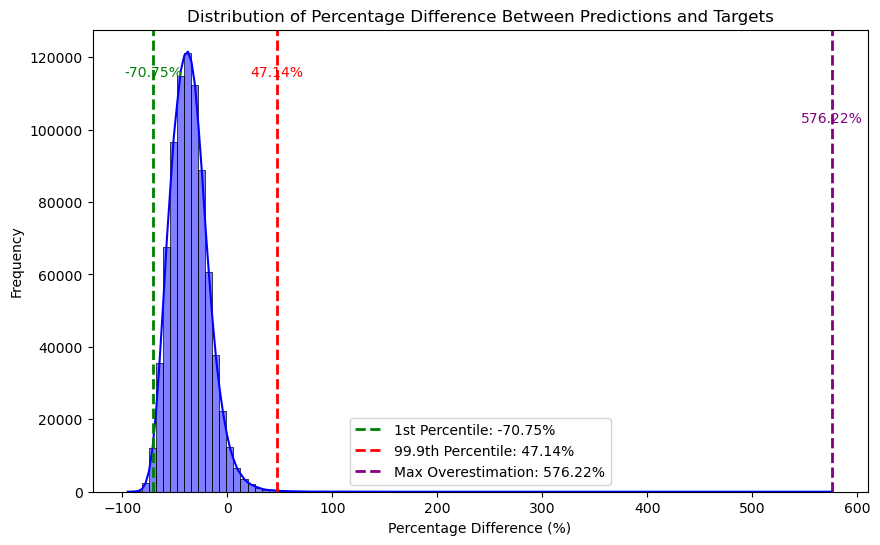

Maximal Overestimation Value: 576.22%
Percentile for 0 on x-axis value: 96.85%


In [ ]:
percentage_difference = ((y_pred - y_test) / y_test) * 100

percentile_1 = np.percentile(percentage_difference, 1)
percentile_99 = np.percentile(percentage_difference, 99.9)
max_overestimation = np.max(percentage_difference)
percentile_of_0 = percentileofscore(percentage_difference, 0)

plt.figure(figsize=(10, 6))
sns.histplot(percentage_difference, kde=True, bins=100, color='blue')

plt.axvline(percentile_1, color='green', linestyle='--', linewidth=2, label=f'1st Percentile: {percentile_1:.2f}%')
plt.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99.9th Percentile: {percentile_99:.2f}%')

plt.text(percentile_1, plt.ylim()[1] * 0.9, f'{percentile_1:.2f}%', color='green', ha='center')
plt.text(percentile_99, plt.ylim()[1] * 0.9, f'{percentile_99:.2f}%', color='red', ha='center')

plt.axvline(max_overestimation, color='purple', linestyle='--', linewidth=2, label=f'Max Overestimation: {max_overestimation:.2f}%')
plt.text(max_overestimation, plt.ylim()[1] * 0.8, f'{max_overestimation:.2f}%', color='purple', ha='center')

plt.xlabel('Percentage Difference (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Difference Between Predictions and Targets')
plt.legend()
plt.show()

print(f'Maximal Overestimation Value: {max_overestimation:.2f}%')
print(f'Percentile for 0 on x-axis value: {percentile_of_0:.2f}%')

## Forward pass time

In [ ]:
num_iterations = 10000
total_time = 0

for _ in range(num_iterations):
    random_index = np.random.randint(0, X_test.shape[0])
    # single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    start_time = time.perf_counter()
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    end_time = time.perf_counter()
    total_time += (end_time - start_time)

average_forward_pass_time = (total_time / num_iterations) * 1e6
print(f"Average forward pass time for a single row using TensorFlow Lite: {average_forward_pass_time:.6f} microseconds")
print(f"total time for 10000 rows: {total_time*1000} milliseconds")

Average forward pass time for a single row using TensorFlow Lite: 14.872480 microseconds
total time for 10000 rows: 148.72479916084558 milliseconds
